In [1]:
# This project demonstrates the entire machine learning pipeline in Python. 
# The task is to use machine learning techniques to predict patients' obesity levels based on
# various factors including lifestyles and family history, etc.

In [2]:
import pandas as pd
from pandas import merge
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit
from sklearn import datasets
import matplotlib
from matplotlib import pylab as plt
import warnings
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, confusion_matrix
import shap

df = pd.read_csv("../data/ObesityDataSet.csv")

Male      1068
Female    1043
Name: Gender, dtype: int64


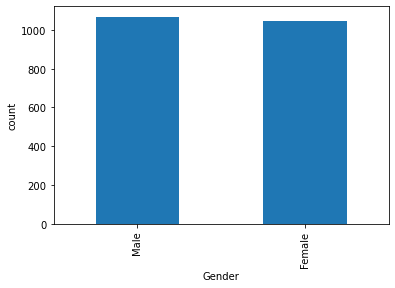

count    2111.000000
mean       24.312600
std         6.345968
min        14.000000
25%        19.947192
50%        22.777890
75%        26.000000
max        61.000000
Name: Age, dtype: float64


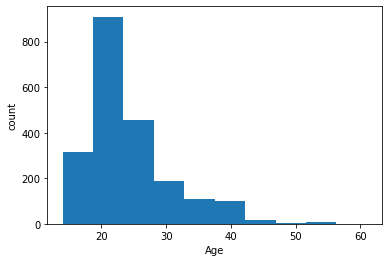

count    2111.000000
mean        1.701677
std         0.093305
min         1.450000
25%         1.630000
50%         1.700499
75%         1.768464
max         1.980000
Name: Height, dtype: float64


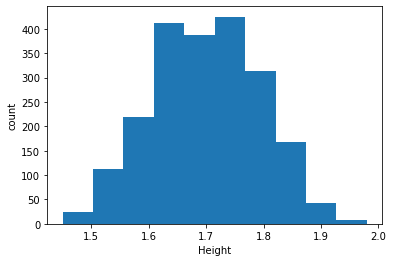

count    2111.000000
mean       86.586058
std        26.191172
min        39.000000
25%        65.473343
50%        83.000000
75%       107.430682
max       173.000000
Name: Weight, dtype: float64


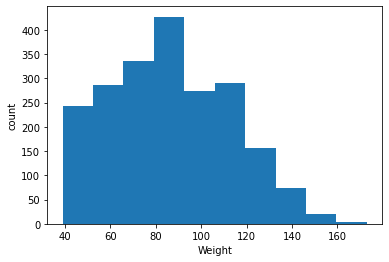

yes    1726
no      385
Name: family_history_with_overweight, dtype: int64


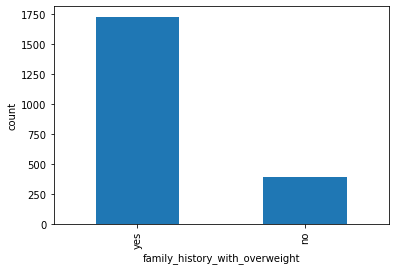

yes    1866
no      245
Name: FAVC, dtype: int64


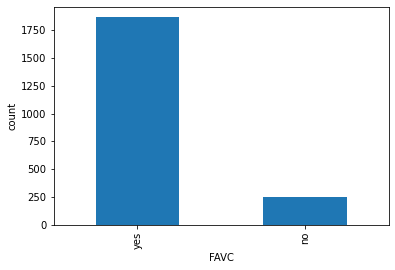

count    2111.000000
mean        2.419043
std         0.533927
min         1.000000
25%         2.000000
50%         2.385502
75%         3.000000
max         3.000000
Name: FCVC, dtype: float64


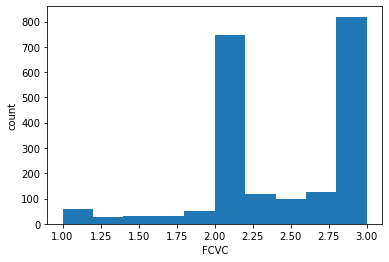

count    2111.000000
mean        2.685628
std         0.778039
min         1.000000
25%         2.658738
50%         3.000000
75%         3.000000
max         4.000000
Name: NCP, dtype: float64


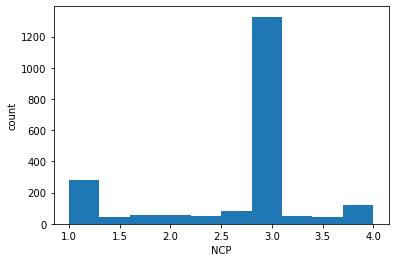

Sometimes     1765
Frequently     242
Always          53
no              51
Name: CAEC, dtype: int64


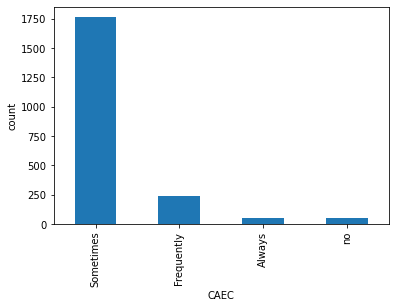

no     2067
yes      44
Name: SMOKE, dtype: int64


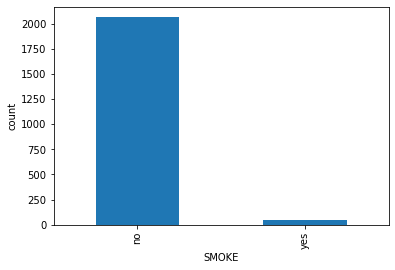

count    2111.000000
mean        2.008011
std         0.612953
min         1.000000
25%         1.584812
50%         2.000000
75%         2.477420
max         3.000000
Name: CH2O, dtype: float64


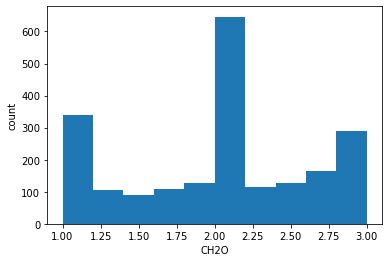

no     2015
yes      96
Name: SCC, dtype: int64


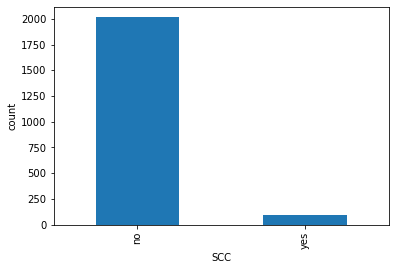

count    2111.000000
mean        1.010298
std         0.850592
min         0.000000
25%         0.124505
50%         1.000000
75%         1.666678
max         3.000000
Name: FAF, dtype: float64


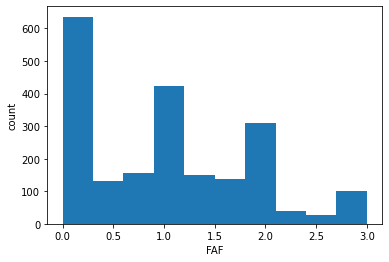

count    2111.000000
mean        0.657866
std         0.608927
min         0.000000
25%         0.000000
50%         0.625350
75%         1.000000
max         2.000000
Name: TUE, dtype: float64


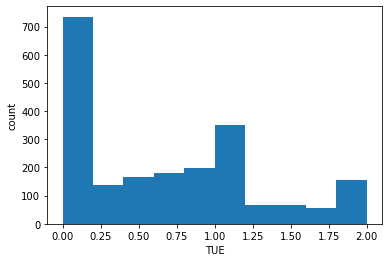

Sometimes     1401
no             639
Frequently      70
Always           1
Name: CALC, dtype: int64


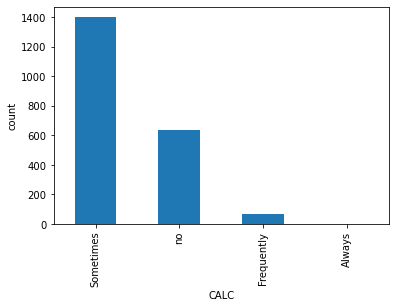

Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: MTRANS, dtype: int64


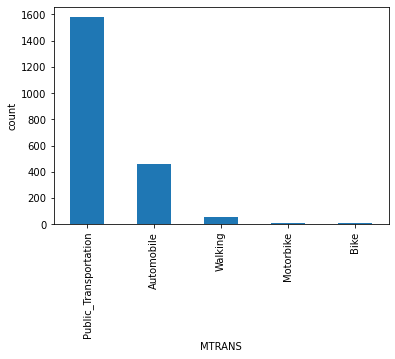

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_II    290
Overweight_Level_I     290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64


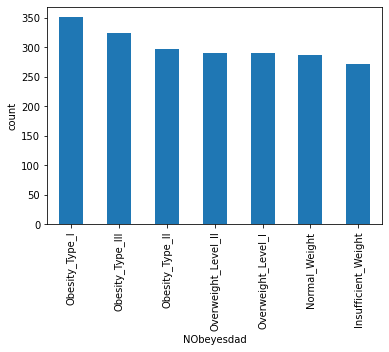

In [3]:
# Perform EDA.
def descount(df,threshold):
    """
    Determine whether each column contains continuous or categorical data by considering whether it
    contains number of unique values greater than threshold. If continuous, use describe() and create
    histogram. If categorical, use value_counts() and create bar plot.
    """
    for column in df:
        col = df[column]
        uniqueval = col.nunique()
        if uniqueval>threshold:
            print(col.describe())
            col.plot.hist(bins = min(uniqueval,10))
            plt.xlabel(column)
            plt.ylabel('count')
            plt.show()
#             plt.savefig('../figures/'+col+'_plot.png')
        else:
            print(col.value_counts())
            pd.value_counts(col).plot.bar()
            plt.xlabel(column)
            plt.ylabel('count')
            plt.show()
#             plt.savefig('../figures/'+col+'_plot.png')
descount(df,10)

In [4]:
# The target variable. It seems the target variable is well balanced.

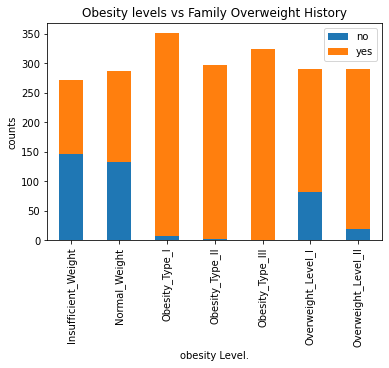

In [5]:
# Visualize obesity level distribution based on family overweight history.
count_matrix = df.groupby(['NObeyesdad', 'family_history_with_overweight']).size().unstack()
# count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix.plot(kind='bar', stacked=True)
plt.title('Obesity levels vs Family Overweight History')
plt.xlabel('obesity Level.')
plt.ylabel('counts')
plt.legend(loc=1)
plt.show()
# plt.savefig('../figures/'+'Obesity family history'+'_plot.png')

In [6]:
count_matrix

family_history_with_overweight,no,yes
NObeyesdad,,
Insufficient_Weight,146.0,126.0
Normal_Weight,132.0,155.0
Obesity_Type_I,7.0,344.0
Obesity_Type_II,1.0,296.0
Obesity_Type_III,NaN,324.0
Overweight_Level_I,81.0,209.0
Overweight_Level_II,18.0,272.0


In [7]:
# Split the data into train, validation and test sets.
rs = 42
X = df.loc[:, df.columns != 'NObeyesdad']
y = df['NObeyesdad']
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2, stratify = X['MTRANS'],random_state=rs)
# kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=rs)
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=rs)
for train_idx, val_index in kf.split(X_other, y_other):
    X_train = X_other.iloc[train_idx]
    y_train = y_other.iloc[train_idx]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    print(y_other.value_counts(normalize=False))

Obesity_Type_I         276
Obesity_Type_III       256
Overweight_Level_I     243
Normal_Weight          233
Obesity_Type_II        233
Overweight_Level_II    228
Insufficient_Weight    219
Name: NObeyesdad, dtype: int64
Obesity_Type_I         276
Obesity_Type_III       256
Overweight_Level_I     243
Normal_Weight          233
Obesity_Type_II        233
Overweight_Level_II    228
Insufficient_Weight    219
Name: NObeyesdad, dtype: int64
Obesity_Type_I         276
Obesity_Type_III       256
Overweight_Level_I     243
Normal_Weight          233
Obesity_Type_II        233
Overweight_Level_II    228
Insufficient_Weight    219
Name: NObeyesdad, dtype: int64


In [8]:
# Encode and scale the features.
oe_ftrs = ['CAEC','CALC'] 
oe_cats = [['no','Sometimes','Frequently','Always'],['no','Sometimes','Frequently','Always']]
oh_ftrs = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','MTRANS']
ss_ftrs = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
oe = OrdinalEncoder(categories = oe_cats) 
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')


ss = StandardScaler()
le = LabelEncoder()

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = oe_cats), oe_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), oh_ftrs),
        ('std', StandardScaler(), ss_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)
y_train_prep = le.fit_transform(y_train)
y_val_prep = le.transform(y_val)
y_test_prep = le.transform(y_test)

In [10]:
def ML_pipeline_kfold(X,y,rs,n_folds,ML_algo,param_grid):
  """Construct a machine learning pipeline including splitting the data, preprocessing the data, and training the model. """
  # create a test set
  X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=rs)
  # splitter for _other
  kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=rs)
  # create the pipeline: preprocessor + supervised ML method
  cat_ftrs = ['Gender','family_history_with_overweight','FAVC','SMOKE','SCC','MTRANS']
  ordinal_ftrs = ['CAEC','CALC']
  ordinal_cats = [['no','Sometimes','Frequently','Always'],['no','Sometimes','Frequently','Always']]
  num_ftrs = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','TUE']
  # one-hot encoder
  categorical_transformer = Pipeline(steps=[
      ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

  # ordinal encoder
  ordinal_transformer = Pipeline(steps=[
      ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

  # standard scaler
  numeric_transformer = Pipeline(steps=[
      ('scaler', StandardScaler())])

  # collect the transformers
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, num_ftrs),
          ('cat', categorical_transformer, cat_ftrs),
          ('ord', ordinal_transformer, ordinal_ftrs)])
  le = LabelEncoder()
  X_other_prep = preprocessor.fit_transform(X_other)
  X_test_prep = preprocessor.transform(X_test)
  y_other_prep = le.fit_transform(y_other)
  y_test_prep = le.transform(y_test)
  pipe = make_pipeline(ML_algo)
  # print(pipe.get_params().keys())
  grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
  # do kfold CV on _other
  grid.fit(X_other_prep, y_other_prep)
  feature_names = num_ftrs + ordinal_ftrs+ \
              list(preprocessor.named_transformers_['cat'][0].get_feature_names(cat_ftrs))
  y_test_pred = grid.predict(X_test_prep)
  X_other2 = pd.DataFrame(data=X_other_prep,columns = feature_names)
  X_test2 = pd.DataFrame(data=X_test_prep,columns = feature_names)
  train_results = {"grid":grid, "feature_names": feature_names, "x_other": X_other2, "y_other": y_other_prep,
             "x_test": X_test2, "y_test":y_test_prep, "y_pred": y_test_pred, "preprocessor": preprocessor,
             "pipeline": pipe, "le": le}
  return train_results

In [11]:
# Evaluate and compare different models.
def eval_algo(X,y,rs,n_folds,ML_algo,param_grid,algo=None):
    acc_score = []
    prc_score = []
    rec_score = []
    f_half_score = []
    f_one_score = []
    f_two_score = []
    best_params = []
    for m in rs:
        train_results = ML_pipeline_kfold(X,y,m,n_folds,ML_algo,param_grid)
        acc_score.append(accuracy_score(train_results["y_test"],train_results["y_pred"]))
        prc_score.append(precision_score(train_results["y_test"],train_results["y_pred"], average = 'weighted'))
        rec_score.append(recall_score(train_results["y_test"],train_results["y_pred"], average = 'weighted'))
        f_half_score.append(fbeta_score(train_results["y_test"],train_results["y_pred"], beta = 0.5, average = 'weighted'))
        f_one_score.append(fbeta_score(train_results["y_test"],train_results["y_pred"], beta = 1, average = 'weighted'))
        f_two_score.append(fbeta_score(train_results["y_test"],train_results["y_pred"], beta = 2, average = 'weighted'))
        best_params.append(train_results["grid"].best_params_)
    eval_results = {"accuracy":acc_score, "precision": prc_score, "recall": rec_score, "f0.5": f_half_score,
                    "f1": f_one_score, "f2": f_two_score, "best_params": best_params}
    return train_results, eval_results

In [12]:
rs = [42*m for m in range(5)]
n_folds = 3
dm_algo = DummyClassifier(strategy = "most_frequent")
dm_param = {}
alpha = np.logspace(-2,2,11)
lr_algo = LogisticRegression(penalty = 'elasticnet',solver = 'saga', max_iter = 10000)
lr_param = {'logisticregression__C': 1./alpha,
             'logisticregression__l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
rf_algo = RandomForestClassifier(n_estimators =  100)
rf_param = {'randomforestclassifier__max_depth': [10,30,100,300],
              'randomforestclassifier__max_features':["auto", "sqrt", "log2"],
                  'randomforestclassifier__min_samples_split': [16, 32, 64, 128],
             'randomforestclassifier__min_samples_leaf': [1, 2, 4]}
xgb_algo = xgboost.XGBClassifier()
xgb_param = {"xgbclassifier__learning_rate": [0.03],
              "xgbclassifier__n_estimators": [3000],
              "xgbclassifier__reg_alpha": [1e-2, 1e-1, 1e0],
              "xgbclassifier__reg_lambda": [1e-2, 1e-1, 1e0],
              "xgbclassifier__missing": [np.nan], 
              "xgbclassifier__colsample_bytree": [0.9],
              "xgbclassifier__max_depth": [30, 100],              
              "xgbclassifier__subsample": [0.66]}

In [13]:
dummy_train_results, dummy_eval_results = eval_algo(X,y,rs,n_folds,dm_algo,dm_param)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0040s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [14]:
lr_train_results, lr_eval_results = eval_algo(X,y,rs,n_folds,lr_algo,lr_param)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:  1.9min
[Paralle

Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 121 candidates, totalling 363 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [15]:
rf_train_results, rf_eval_results = eval_algo(X,y,rs,n_folds,rf_algo,rf_param)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [16]:
xgb_train_results, xgb_eval_results = eval_algo(X,y,rs,n_folds,xgb_algo,xgb_param)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:  3.4min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:  3.5min remaining:   53.8s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:  4.0min remaining:   24.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.1min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:  3.4min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:  3.5min remaining:   53.8s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:  3.9min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.0min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:  3.3min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:  3.4min remaining:   52.8s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:  4.0min remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.0min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:  3.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:  3.6min remaining:   55.7s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:  4.0min remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.0min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:  3.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:  3.3min remaining:   50.9s
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:  3.8min remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.8min finished


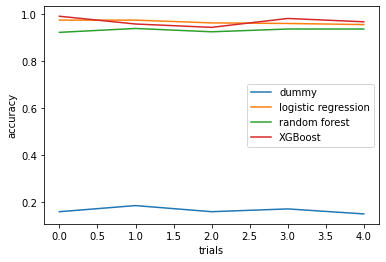

In [17]:
# Compare accuracy.
plt.plot(dummy_eval_results["accuracy"],linestyle = None)
plt.plot(lr_eval_results["accuracy"],linestyle = None)
plt.plot(rf_eval_results["accuracy"],linestyle = None)
plt.plot(xgb_eval_results["accuracy"],linestyle = None)
plt.xlabel('trials')
plt.ylabel('accuracy')
plt.legend(['dummy','logistic regression','random forest','XGBoost'])

In [18]:
lr_eval_results["accuracy"]

[0.9739952718676123,
 0.9739952718676123,
 0.9621749408983451,
 0.9598108747044918,
 0.9550827423167849]

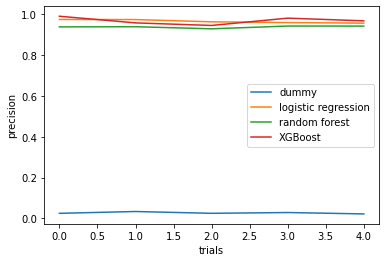

In [19]:
# Compare precision.
plt.plot(dummy_eval_results["precision"],linestyle = None)
plt.plot(lr_eval_results["precision"],linestyle = None)
plt.plot(rf_eval_results["precision"],linestyle = None)
plt.plot(xgb_eval_results["precision"],linestyle = None)
plt.xlabel('trials')
plt.ylabel('precision')
plt.legend(['dummy','logistic regression','random forest','XGBoost'])

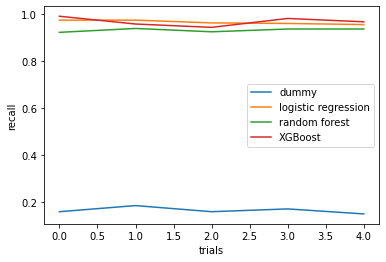

In [20]:
# Compare recall.
plt.plot(dummy_eval_results["recall"],linestyle = None)
plt.plot(lr_eval_results["recall"],linestyle = None)
plt.plot(rf_eval_results["recall"],linestyle = None)
plt.plot(xgb_eval_results["recall"],linestyle = None)
plt.xlabel('trials')
plt.ylabel('recall')
plt.legend(['dummy','logistic regression','random forest','XGBoost'])

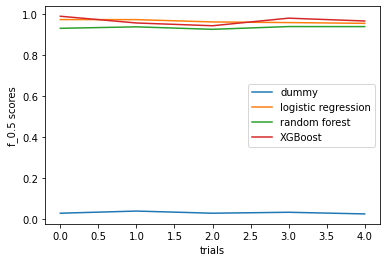

In [21]:
# Compare f_0.5 scores
plt.plot(dummy_eval_results["f0.5"],linestyle = None)
plt.plot(lr_eval_results["f0.5"],linestyle = None)
plt.plot(rf_eval_results["f0.5"],linestyle = None)
plt.plot(xgb_eval_results["f0.5"],linestyle = None)
plt.xlabel('trials')
plt.ylabel('f_0.5 scores')
plt.legend(['dummy','logistic regression','random forest','XGBoost'])

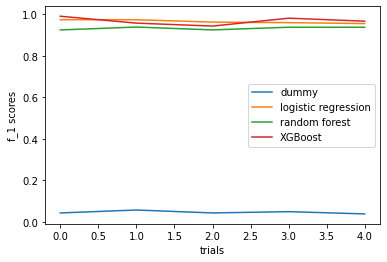

In [22]:
# Compare f_1 scores.
plt.plot(dummy_eval_results["f1"],linestyle = None)
plt.plot(lr_eval_results["f1"],linestyle = None)
plt.plot(rf_eval_results["f1"],linestyle = None)
plt.plot(xgb_eval_results["f1"],linestyle = None)
plt.xlabel('trials')
plt.ylabel('f_1 scores')
plt.legend(['dummy','logistic regression','random forest','XGBoost'])

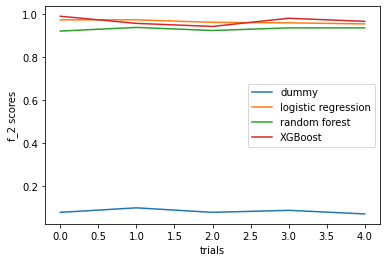

In [23]:
# Compare f_2 scores.
plt.plot(dummy_eval_results["f2"],linestyle = None)
plt.plot(lr_eval_results["f2"],linestyle = None)
plt.plot(rf_eval_results["f2"],linestyle = None)
plt.plot(xgb_eval_results["f2"],linestyle = None)
plt.xlabel('trials')
plt.ylabel('f_2 scores')
plt.legend(['dummy','logistic regression','random forest','XGBoost'])

In [24]:
# Visualize feature importance.
shap.initjs() # required for visualizations later on
# create the explainer object
explainer = shap.LinearExplainer(lr_train_results["grid"].best_estimator_[0], lr_train_results["x_test"])
# X_test_transformed = lr_train_results["grid"].best_estimator_[0].transform(lr_train_results["x_test"])
print(np.shape(lr_train_results["x_test"]))
shap_values_lr = explainer.shap_values(lr_train_results["x_test"])
print(np.shape(shap_values_lr))

(423, 25)
(7, 423, 25)


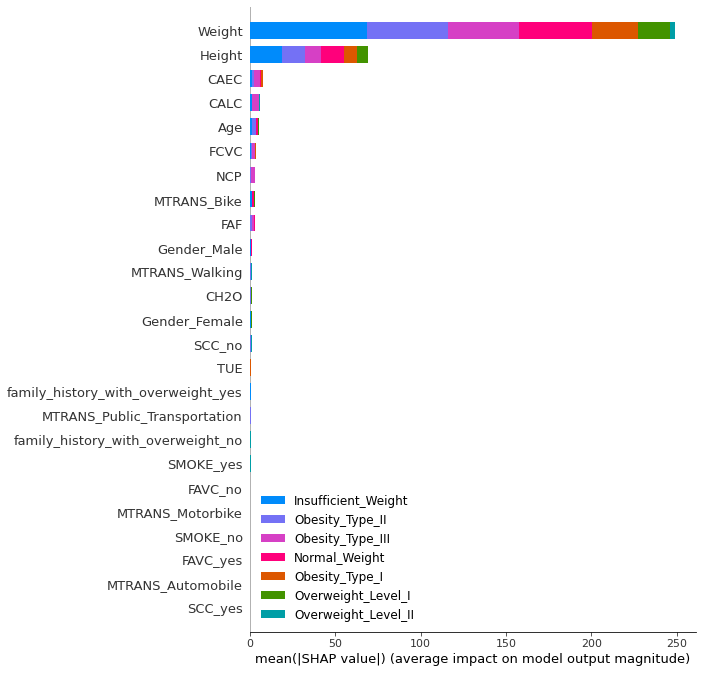

In [25]:
# It seems height and weight are two dominant factors for determinining a person's obesity (obviously).
shap.summary_plot(shap_values_lr,features = lr_train_results["x_test"], max_display = 25,
                  class_names=lr_train_results["le"].classes_)

In [26]:
shap.force_plot(explainer.expected_value[0], shap_values_lr[0][3,:], lr_train_results["x_test"].iloc[3,:])

In [27]:
shap.force_plot(explainer.expected_value[1], shap_values_lr[1][3,:], lr_train_results["x_test"].iloc[3,:])

In [28]:
shap.force_plot(explainer.expected_value[2], shap_values_lr[2][3,:], lr_train_results["x_test"].iloc[3,:])

In [29]:
shap.force_plot(explainer.expected_value[3], shap_values_lr[3][3,:], lr_train_results["x_test"].iloc[3,:])

In [50]:
# Conduct a permutation feature importance experiment.

def perturb_scores(results,nr_runs):
    acc_scores = np.zeros([len(results["feature_names"]),nr_runs])
    prc_scores = np.zeros([len(results["feature_names"]),nr_runs])
    rec_scores = np.zeros([len(results["feature_names"]),nr_runs])
    f_half_scores = np.zeros([len(results["feature_names"]),nr_runs])
    f_one_scores = np.zeros([len(results["feature_names"]),nr_runs])
    f_two_scores = np.zeros([len(results["feature_names"]),nr_runs])
    # loop through the features
    for i in range(len(results["feature_names"])):
        acc_score = []
        prc_score = []
        rec_score = []
        f_half_score = []
        f_one_score = []
        f_two_score = []
        for j in range(nr_runs):
            df_test_shuffled = results["x_test"].copy()
            X_column = df_test_shuffled[results["feature_names"][i]]
            X_column_perm = np.random.permutation(X_column.values)
            df_test_shuffled[results["feature_names"][i]] = X_column_perm
            estimator = results["grid"].best_estimator_
            df_value = df_test_shuffled.values
            df_test_shuffled = pd.DataFrame(data = df_value, columns = results["feature_names"])
            y_test_shuffled = estimator.predict(df_test_shuffled.values)
            acc_score.append(accuracy_score(results["y_test"],y_test_shuffled))
            prc_score.append(precision_score(results["y_test"],y_test_shuffled, average = 'weighted'))
            rec_score.append(recall_score(results["y_test"],y_test_shuffled, average = 'weighted'))
            f_half_score.append(fbeta_score(results["y_test"],y_test_shuffled, beta = 0.5, average = 'weighted'))
            f_one_score.append(fbeta_score(results["y_test"],y_test_shuffled, beta = 1, average = 'weighted'))
            f_two_score.append(fbeta_score(results["y_test"],y_test_shuffled, beta = 2, average = 'weighted'))
        acc_scores[i] = acc_score
        prc_scores[i] = prc_score
        rec_scores[i] = rec_score
        f_half_scores[i] = f_half_score 
        f_one_scores[i] = f_one_score 
        f_two_scores[i] = f_two_score
    y_test_pred = results["grid"].best_estimator_.predict(results["x_test"])
    acc_test = accuracy_score(results["y_test"],y_test_pred)
    prc_test = precision_score(results["y_test"],y_test_pred, average = 'weighted')
    rec_test = recall_score(results["y_test"],y_test_pred, average = 'weighted')
    f_half_test = fbeta_score(results["y_test"],y_test_pred, beta = 0.5, average = 'weighted')
    f_one_test = fbeta_score(results["y_test"],y_test_pred, beta = 1, average = 'weighted')
    f_two_test = fbeta_score(results["y_test"],y_test_pred, beta = 2, average = 'weighted')
    
    perturb_results = {"accuracy":acc_scores, "precision":prc_scores, "recall": rec_scores, "f0.5": f_half_scores,
                       "f1": f_one_scores, "f2": f_two_scores, "accuracy_test": acc_test, "precision_test": prc_test,
                       "recall_test": rec_test, "f0.5_test": f_half_test, "f1_test": f_one_test, "f2_test": f_two_test}
    return perturb_results

In [59]:
nr_runs = 100
dummy_perturb_results = perturb_scores(dummy_train_results,nr_runs)

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [60]:
lr_perturb_results = perturb_scores(lr_train_results,nr_runs)

In [61]:
rf_perturb_results = perturb_scores(rf_train_results,nr_runs)

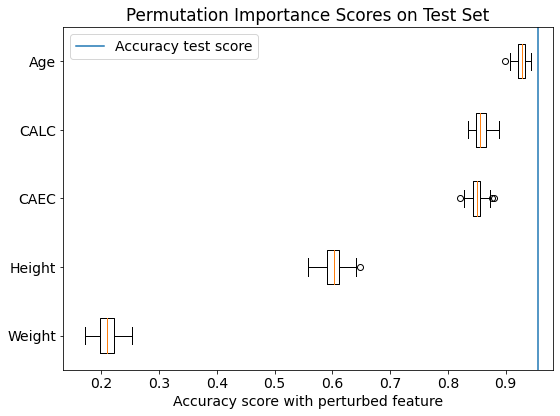

In [62]:
# Plot permutation importance scores for the 5 most significant features.
acc_sorted_indcs = np.argsort(np.mean(lr_perturb_results["accuracy"],axis=1))
acc_sorted_indcs = acc_sorted_indcs[0:5]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(lr_perturb_results["accuracy"][acc_sorted_indcs].T,labels=np.array(lr_train_results["feature_names"])
            [acc_sorted_indcs],vert=False)
plt.axvline(lr_perturb_results["accuracy_test"],label='Accuracy test score')
plt.title("Permutation Importance Scores on Test Set")
plt.xlabel('Accuracy score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()